In [2]:
#import necessary packages

#our workhorses
import numpy as np
import pandas as pd
import scipy

#to visualize
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#style params for figures
sns.set(font_scale = 2)
plt.style.use('seaborn-white')
plt.rc("axes", labelweight="bold")
from IPython.display import display, HTML

#to load files
import os
import h5py

#for stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multitest as multitest
import statsmodels.stats.multicomp

#load custon functions
from EMG_gestures.utils import *

In [3]:
results_folder = '../results_data/xsubject_joint_data/log_reg'

results_df = []
for model_id in range(1,5):
    # load model results
    results_fn = 'model_%02d_results.h5'%(model_id)
    model_df = pd.read_hdf(os.path.join(results_folder,results_fn), 'results_df')
    model_df['Model'] = model_id
    #append to collective dataframe
    results_df.append(model_df)
results_df = pd.concat(results_df,axis = 0)

In [4]:
# Average over multiple train/test splits of the data
results_df = results_df.groupby(['Shuffled','Type','Model','Rep'],as_index = False)\
.mean()\
.drop(columns = ['Fold'])

In [5]:
results_df

,Shuffled,Type,Model,Rep,f1_score,accuracy_score
0,False,Test,1,1,0.777481,0.778920
1,False,Test,1,2,0.789419,0.790022
2,False,Test,1,3,0.773998,0.774971
3,False,Test,1,4,0.791248,0.793899
4,False,Test,1,5,0.771974,0.774919
...,...,...,...,...,...,...
155,True,Train,4,6,0.202741,0.224368
156,True,Train,4,7,0.210725,0.228974
157,True,Train,4,8,0.213854,0.228137
158,True,Train,4,9,0.210528,0.238447


In [6]:
#drop accuracy score, working with f1 score
results_df = results_df.drop(columns=['accuracy_score'])

train_results_df = results_df.loc[results_df.Type == 'Train']
test_results_df = results_df.loc[results_df.Type == 'Test']

train_summary = train_results_df.groupby(['Shuffled','Model']).mean().\
drop(columns=['Rep']).\
rename(columns={'f1_score':'Train_score'})

test_summary = test_results_df.groupby(['Shuffled','Model']).mean().\
drop(columns=['Rep']).\
rename(columns={'f1_score':'Test_score'})

summary_df = pd.concat([train_summary,test_summary],axis = 1)
summary_df

Train_score  Test_score
Shuffled Model                         
False    1         0.826332    0.783888
         2         0.844863    0.792987
         3         0.843371    0.783586
         4         0.834645    0.789280
True     1         0.203693    0.151368
         2         0.216268    0.148044
         3         0.233070    0.145805
         4         0.207238    0.146180

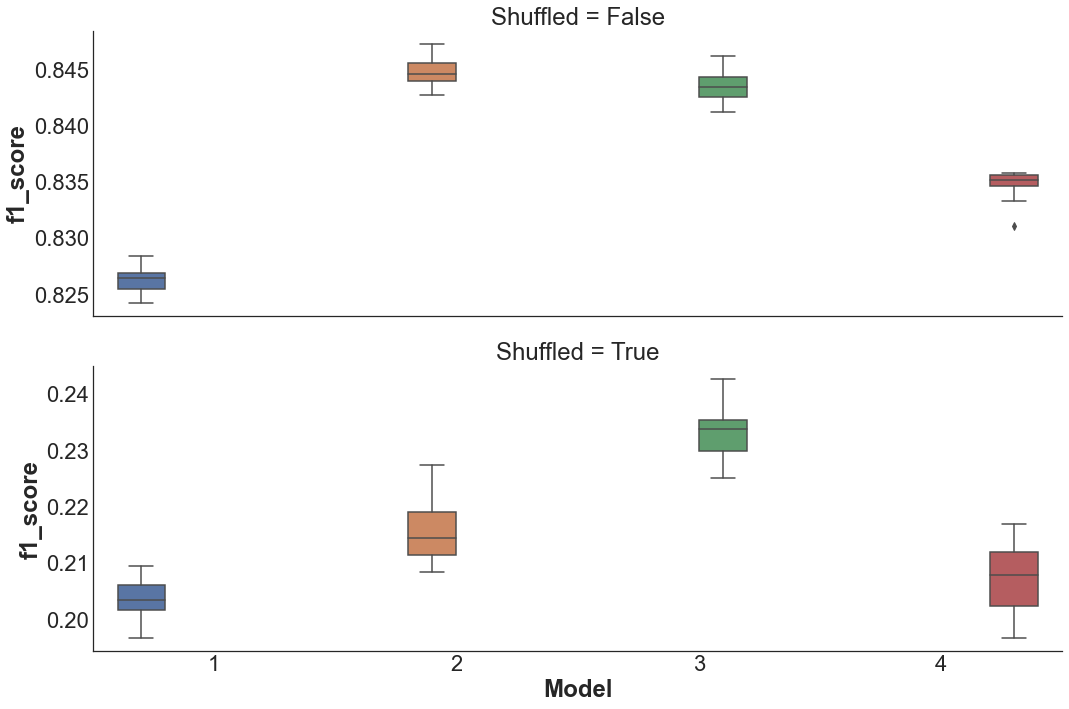

In [7]:


g = sns.catplot(data = train_results_df, x= 'Model', y = 'f1_score', col = 'Shuffled', hue = 'Model',\
            kind = 'box', col_order = [False,True], col_wrap = 1, aspect = 3, sharey = False)

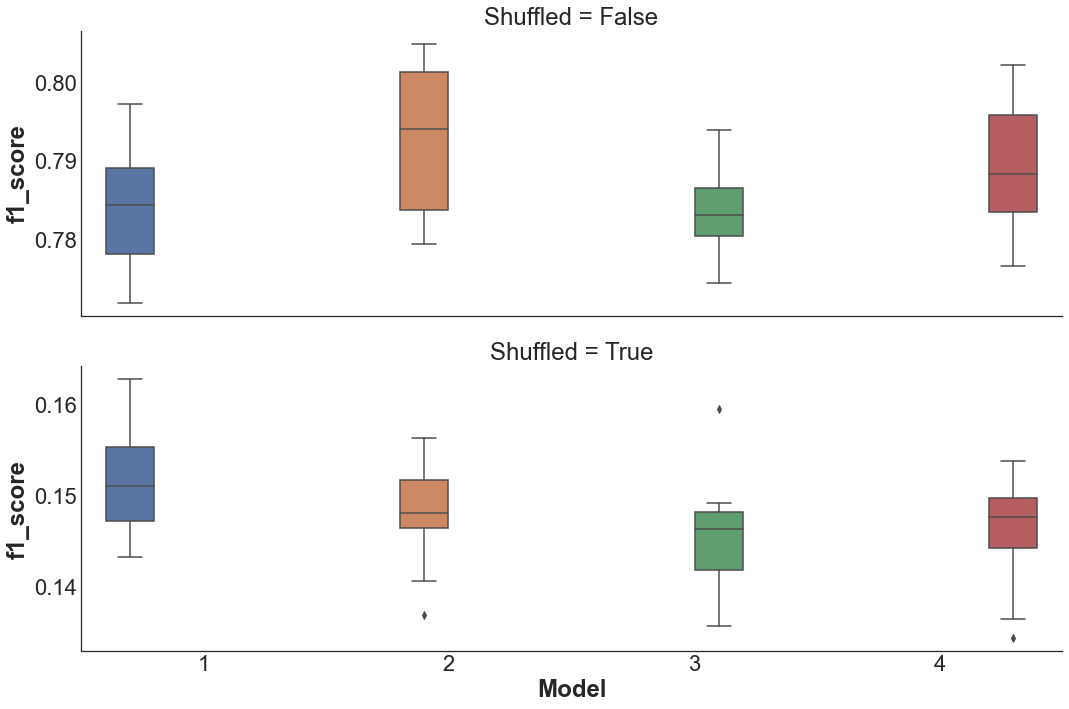

In [8]:
g = sns.catplot(data = test_results_df, x= 'Model', y = 'f1_score', col = 'Shuffled', hue = 'Model',\
            kind = 'box', col_order = [False,True], col_wrap = 1, aspect = 3, sharey = False)

In [12]:
results_true_df = results_df.loc[results_df.Shuffled == False]

In [13]:
# Run ANOVA
model = ols('F1_score ~ C(Model)*C(Type)', results_true_df).fit()

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

,sum_sq,df,F,PR(>F)
C(Model),0.002719,3.0,27.033662,8.072277e-12
C(Type),0.053851,1.0,1606.210252,5.630225e-51
C(Model):C(Type),0.000708,3.0,7.035046,3.254785e-04
Residual,0.002414,72.0,NaN,NaN


In [14]:
groups =  results_true_df['Model'].map(str) + ' - ' + results_true_df['Type'].map(str)

mc = statsmodels.stats.multicomp.MultiComparison(results_true_df['F1_score'],groups)
mc_results = mc.tukeyhsd()
print(mc_results)


   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
 1 - Test 1 - Train   0.0471  0.001   0.039  0.0552   True
 1 - Test  2 - Test   0.0139  0.001  0.0058   0.022   True
 1 - Test 2 - Train    0.066  0.001  0.0579  0.0741   True
 1 - Test  3 - Test   0.0025    0.9 -0.0056  0.0106  False
 1 - Test 3 - Train    0.064  0.001  0.0559  0.0721   True
 1 - Test  4 - Test   0.0091 0.0173   0.001  0.0172   True
 1 - Test 4 - Train   0.0559  0.001  0.0478  0.0639   True
1 - Train  2 - Test  -0.0332  0.001 -0.0413 -0.0251   True
1 - Train 2 - Train   0.0189  0.001  0.0108   0.027   True
1 - Train  3 - Test  -0.0446  0.001 -0.0527 -0.0365   True
1 - Train 3 - Train   0.0169  0.001  0.0088   0.025   True
1 - Train  4 - Test   -0.038  0.001 -0.0461   -0.03   True
1 - Train 4 - Train   0.0087 0.0247  0.0007  0.0168   True
 2 - Test 2 - Train   0.0521  0.001  0.0441  0.0602   Tr

In [15]:
test_results_true_df = results_df.loc[(results_df.Type == 'Test')&(results_df.Shuffled == False)]
train_results_true_df = results_df.loc[(results_df.Type == 'Train')&(results_df.Shuffled == False)]


In [16]:
# Run ANOVA
model = ols('F1_score ~ C(Model)', train_results_true_df).fit()

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

,sum_sq,df,F,PR(>F)
C(Model),0.002233,3.0,173.925016,1.788361e-21
Residual,0.000154,36.0,NaN,NaN


In [17]:
groups =  train_results_true_df['Model'].map(str) #+ ' - ' + test_results_true_df['Shuffled'].map(str)

mc = statsmodels.stats.multicomp.MultiComparison(train_results_true_df['F1_score'],groups)
mc_results = mc.tukeyhsd()
print(mc_results)

#p_values = psturng(np.abs(mc_results.meandiffs / mc_results.std_pairs), len(mc_results.groupsunique), mc_results.df_total)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   0.0189  0.001  0.0164  0.0214   True
     1      3   0.0169  0.001  0.0144  0.0194   True
     1      4   0.0087  0.001  0.0063  0.0112   True
     2      3   -0.002 0.1468 -0.0045  0.0005  False
     2      4  -0.0102  0.001 -0.0127 -0.0077   True
     3      4  -0.0081  0.001 -0.0106 -0.0056   True
----------------------------------------------------


In [18]:
#put things in dataframe and sort
summary_df.reset_index().loc[summary_df.reset_index().Shuffled == False].\
sort_values(by=['Train_score','Test_score'],ascending = False)#.reset_index().lo

,Shuffled,Model,Train_score,Test_score
1,False,2,0.844987,0.792849
2,False,3,0.842966,0.781450
3,False,4,0.834826,0.788032
0,False,1,0.826076,0.778965


<AxesSubplot:>

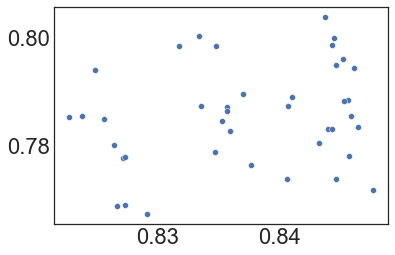

In [19]:
#checking correlaiton between train and test values - True data

X = results_df.loc[(results_df.Type == 'Train')&(results_df.Shuffled == False)]['F1_score'].values
Y = results_df.loc[(results_df.Type == 'Test')&(results_df.Shuffled == False)]['F1_score'].values

sns.scatterplot(x = X, y = Y)

<AxesSubplot:>

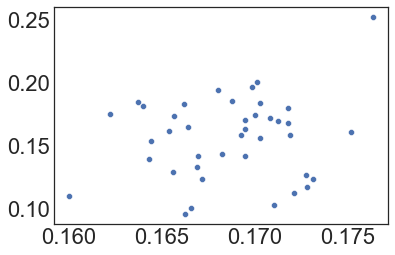

In [20]:
#checking correlaiton between train and test values - Shuffled data
X = results_df.loc[(results_df.Type == 'Train')&(results_df.Shuffled == True)]['F1_score'].values
Y = results_df.loc[(results_df.Type == 'Test')&(results_df.Shuffled == True)]['F1_score'].values

sns.scatterplot(x = X, y = Y)

In [17]:
X = results_df.loc[(results_df.Type == 'Train')&(results_df.Type == 'Test')]

In [18]:
results_df.loc[results_df.Type=='Test','Type'] = 'Validation'

In [31]:
#define where the data files are located
data_folder = './EMG_data/'

nsubjects = 36

#randomly-selected subjects to use as hold-out test data 
test_subjects = np.array([17, 23,  7,  8,  3])

# User-defined parameters
lo_freq = 20 #lower bound of bandpass filter
hi_freq = 450 #upper bound of bandpass filter

win_size = 100 #define window size over which to compute time-domain features
step = win_size #keeping this parameter in case we want to re-run later with some overlap

#excluded labels
exclude = [0,7]

#intialize empty lists
feature_matrix_all = np.empty((0,0))
target_labels_all = np.empty((0,))
window_tstamps_all = np.empty((0,))
block_labels_all  = np.empty((0,))
series_labels_all  = np.empty((0,))

subject_id_all = np.empty((0,))
block_count = 0

for subject_id in test_subjects:

    subject_folder = os.path.join(data_folder,'%02d'%(subject_id))
    print('=======================')
    print(subject_folder)

    # Process data and get features 
    #get features across segments and corresponding info
    feature_matrix, target_labels, window_tstamps, \
    block_labels, series_labels = get_subject_data_for_classification(subject_folder, lo_freq, hi_freq, \
                                                                    win_size, step)

    #prevent repeat of block labels by increasing block count
    block_labels = block_labels+block_count
    block_count = np.max([block_count, np.max(block_labels)])
    #exclude indicated samples
    in_samples = np.where(np.isin(target_labels,exclude, invert = True))[0]
    feature_matrix_in = feature_matrix[in_samples,:]
    target_labels_in = target_labels[in_samples]
    window_tstamps_in = window_tstamps[in_samples]
    block_labels_in = block_labels[in_samples]
    series_labels_in = series_labels[in_samples]
    # concatenate lists
    feature_matrix_all = np.vstack((feature_matrix_all,feature_matrix_in)) if feature_matrix_all.size else feature_matrix_in
    target_labels_all = np.hstack((target_labels_all,target_labels_in))
    window_tstamps_all = np.hstack((window_tstamps_all,window_tstamps_in))
    block_labels_all = np.hstack((block_labels_all,block_labels_in))
    series_labels_all = np.hstack((series_labels_all,series_labels_in))
    subject_id_all = np.hstack((subject_id_all,np.ones((block_labels_in.size))*subject_id))


./EMG_data/17
./EMG_data/23
./EMG_data/07
./EMG_data/08
./EMG_data/03


In [32]:
def permute_class_within_sub(target_labels, block_labels, sub_labels):
    subs = np.unique(sub_labels)
    #permute labels within each subject
    class_perm = np.empty((0,))
    for s in subs:
        sub_idxs = np.where(sub_labels==s)[0]
        blocks_sub = block_labels[sub_idxs]
        class_sub = target_labels[sub_idxs]

        class_sub_perm, dummy = permute_class_blocks(blocks_sub, class_sub)
        class_perm = np.hstack((class_perm, class_sub_perm))
    target_labels = class_perm.copy()
    return target_labels

In [33]:
import pickle
from tensorflow import keras

In [34]:
model_folder = './model_data/xsubject_joint_data/RNN/'
#load scaler
scaler_fn = 'scaler_all_training_data.pkl'
with open(os.path.join(model_folder,scaler_fn), "rb") as input_file:
    scaler = pickle.load(input_file)

/Users/cesar/anaconda2/envs/EMG/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [35]:
test_results_df = []
nreps = 10
for rep in range(nreps):
    model_fn = os.path.join(model_folder, 'model_rep_%i_all_train_data.h5'%(rep))
    trained_model = keras.models.load_model(model_fn)
    
    target_labels_perm = permute_class_within_sub(target_labels_all, block_labels_all, subject_id_all)

    test_f1_scores = np.empty((test_subjects.size))
    test_f1_perm_scores = np.empty((test_subjects.size))
    for sub_idx, subject_id in enumerate(test_subjects):
        print(subject_id, rep)

        sub_idxs = np.where(subject_id_all==subject_id)[0]
        X_test = feature_matrix_all[sub_idxs,:].T
        y_test = target_labels_all[sub_idxs]
        #one-hot encoding of class labels
        y_test = to_categorical(y_test-np.min(y_test))
        win_blocks_test = block_labels_all[sub_idxs]

        # select test data and pad to get an array where each sample has same number of timesteps

        #get data cube
        X_test_cube, Y_test_cube, scaler = get_data_cube(X_test, y_test, win_blocks_test, train = False, scaler = scaler, magic_value = -100)

        test_f1_scores[sub_idx] = get_RNN_f1(X_test_cube, Y_test_cube, trained_model)
        
        y_test = target_labels_perm[sub_idxs]
        y_test = to_categorical(y_test-np.min(y_test))
        #get data cube
        X_test_cube, Y_test_cube, scaler = get_data_cube(X_test, y_test, win_blocks_test, train = False, scaler = scaler, magic_value = -100)

        test_f1_perm_scores[sub_idx] = get_RNN_f1(X_test_cube, Y_test_cube, trained_model)
        
    #put results in dataframe
    test_results_df.append(pd.DataFrame({'F1_score':test_f1_scores,\
                                         'Subject':test_subjects,\
                'Rep':[rep+1 for x in range(test_f1_scores.size)],\
                'Type':['Test' for x in range(test_f1_scores.size)],\
                'Shuffled':[False for x in range(test_f1_scores.size)]
                }))
    test_results_df.append(pd.DataFrame({'F1_score':test_f1_perm_scores,\
                                         'Subject':test_subjects,\
                'Rep':[rep+1 for x in range(test_f1_perm_scores.size)],\
                'Type':['Test' for x in range(test_f1_perm_scores.size)],\
                'Shuffled':[True for x in range(test_f1_perm_scores.size)]
                }))
test_results_df = pd.concat(test_results_df, axis = 0)

17 0
23 0
7 0
8 0
3 0
17 1
23 1
7 1
8 1
3 1
17 2
23 2
7 2
8 2
3 2
17 3
23 3
7 3
8 3
3 3
17 4
23 4
7 4
8 4
3 4
17 5
23 5
7 5
8 5
3 5
17 6
23 6
7 6
8 6
3 6
17 7
23 7
7 7
8 7
3 7
17 8
23 8
7 8
8 8
3 8
17 9
23 9
7 9
8 9
3 9


In [48]:
test_results_df.groupby(['Type','Shuffled','Subject']).mean()

F1_score  Rep
Type Shuffled Subject               
Test False    3        0.917813  5.5
              7        0.441177  5.5
              8        0.949749  5.5
              17       0.931676  5.5
              23       0.935168  5.5
     True     3        0.171777  5.5
              7        0.117998  5.5
              8        0.141457  5.5
              17       0.162160  5.5
              23       0.161369  5.5

<AxesSubplot:xlabel='Shuffled', ylabel='F1_score'>

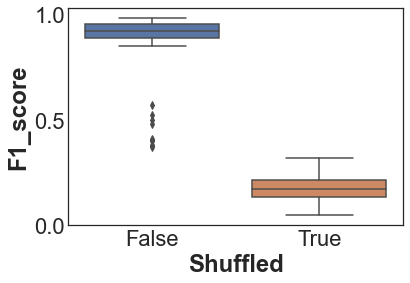

In [36]:
sns.boxplot(data = test_results_df, x = 'Shuffled', y = 'F1_score')

In [37]:
rep = 0
subject_id = test_subjects[0]
model_fn = os.path.join(model_folder, 'model_rep_%i_all_train_data.h5'%(rep))
trained_model = keras.models.load_model(model_fn)


test_f1_scores = np.empty((test_subjects.size))
test_f1_perm_scores = np.empty((test_subjects.size))


print(subject_id, rep)

sub_idxs = np.where(subject_id_all==subject_id)[0]

X_tmp = feature_matrix_all[sub_idxs,:].T
y_tmp = target_labels_all[sub_idxs]

series_idxs = np.where(series_labels_all[sub_idxs]==0)[0]
X_test = X_tmp[:,series_idxs]
y_test = y_tmp[series_idxs]


#one-hot encoding of class labels
y_test = to_categorical(y_test-np.min(y_test))
win_blocks_test = block_labels_all[sub_idxs][series_idxs]

# select test data and pad to get an array where each sample has same number of timesteps

#get data cube
X_test_cube, Y_test_cube, scaler = get_data_cube(X_test, y_test, win_blocks_test, train = False, scaler = scaler, magic_value = -100)

print(get_RNN_f1(X_test_cube, Y_test_cube, trained_model))

17 0
0.8144950000111492


In [77]:
X_test.shape

(16, 207)

In [49]:
X_test_cube.shape

(12, 19, 16)

In [76]:
X = X_test_cube.copy()
Y = Y_test_cube.copy()

nonmasked_idxs = np.where(X[:,:,0].flatten()!=-100)[0]

# Get target labels for non-masked timepoints
y_true_fxn = np.argmax(Y,2).flatten()[nonmasked_idxs]

# Get model predictions for non-masked timepoints
preds = trained_model.predict(X)
y_pred_fxn = np.argmax(preds,2)#.flatten()[nonmasked_idxs]

In [104]:
y_pred_fxn.shape

(12, 19)

In [51]:
y_pred_fn.shape

(12, 19)

In [48]:
X_test.shape

(16, 207)

In [58]:


subject_folder = os.path.join(data_folder,'%02d'%(subject_id))
print('=======================')
print(subject_folder)

# Process data and get features 
#get features across segments and corresponding info
feature_matrix_sub, target_labels_sub, window_tstamps_sub, \
block_labels_sub, series_labels_sub = get_subject_data_for_classification(subject_folder, lo_freq, hi_freq, \
                                                                win_size, step)

./EMG_data/17


In [90]:
blocks = np.array([k for k,g in groupby(block_labels_sub)])
classes = np.array([k for k,g in groupby(target_labels_sub)])

print(blocks,classes)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48.] [0. 1. 0. 2. 0. 3. 0. 4. 0. 5. 0. 6. 0. 1. 0. 2. 0. 3. 0. 4. 0. 5. 0. 6.
 0. 1. 0. 2. 0. 3. 0. 4. 0. 5. 0. 6. 0. 1. 0. 2. 0. 3. 0. 4. 0. 5. 0. 6.
 0.]


In [59]:
feature_matrix_sub.shape

(1346, 16)

In [81]:
X_test.shape

(16, 207)

In [151]:
series_idxs = np.where(series_labels_sub==0)[0]

exclude_idxs = np.where(target_labels_sub[series_idxs]==0)[0]

X_test_sub = feature_matrix_sub[series_idxs,:]
X_test_sub = scaler.transform(X_test_sub)
X_test_sub[exclude_idxs,:] = -100
X_test_sub = np.expand_dims(X_test_sub,0)



In [152]:
y_prob = np.squeeze(trained_model.predict(X_test_sub))

y_pred = np.argmax(y_prob,1)+1

In [150]:
feature_matrix_sub.shape

(1346, 16)

Text(0.5, 1.05, '1_raw_data_11-19_23.03.16.txt')

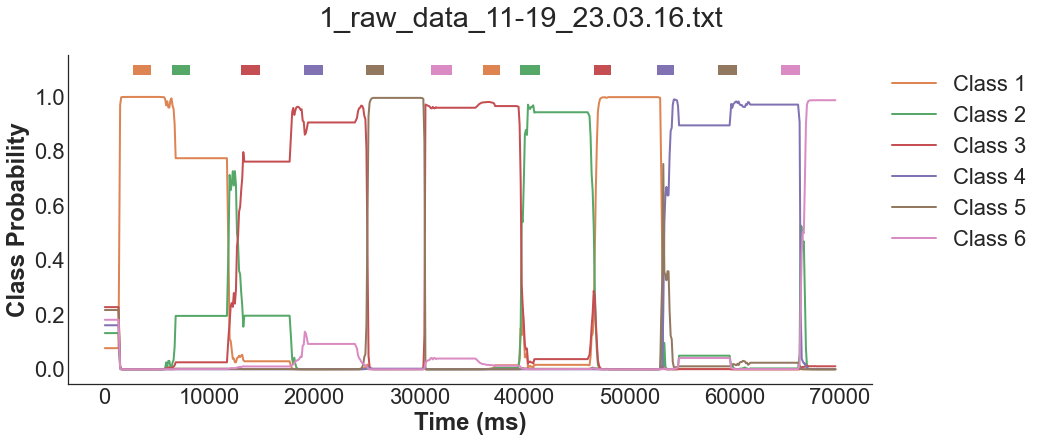

In [153]:


#find files in subject folder
file_list = [f for f in os.listdir(subject_folder) if os.path.isfile(os.path.join(subject_folder, f))]

file_idx = 1

# load file
data_df = pd.DataFrame(pd.read_csv(os.path.join(subject_folder,file_list[file_idx]), sep='\t'))

# retrieve start times, end times, and labels for each condition block (will make it easier to parse traces later)
start_times, end_times, event_labels  = get_gesture_times(data_df)



prob_series = y_prob.copy()
time_series = window_tstamps_sub[series_idxs].copy()

classes = np.unique(event_labels)[1:]#exclude 'unmarked' label
labels = []
for c in classes.astype('int'):
    labels.append('Class %i'%(c))

# define color palette
palette = sns.color_palette('deep',8)[1:]

plt.figure(figsize=(15,6))
plt.gca().set_prop_cycle(plt.cycler('color',palette))
plt.plot(time_series,prob_series, linewidth = 2);

#mark events
for idx,c in enumerate(event_labels):
    if c>0:
        plt.hlines(y = 1.1, xmin = start_times[idx], xmax = end_times[idx], color = palette[c-1],linewidth = 10)

#label axes
plt.ylabel('Class Probability')
plt.xlabel('Time (ms)')

plt.legend(labels, bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

sns.despine(fig= plt.gcf(), left = False, right = True, top = True, bottom = False)

plt.gcf().tight_layout() 

plt.gcf().suptitle('%s'%(file_list[file_idx]), y= 1.05)

In [65]:
y_true = target_labels_sub[series_idxs]

In [66]:
#check f1 score
exclude = [0]
in_samples = np.where(np.isin(target_labels_sub[series_idxs],exclude, invert = True))[0]
y_pred_in = y_pred[in_samples]
y_true_in = y_true[in_samples]
#print(f1_score(y_true,y_pred,average = 'macro'))

In [75]:
y_pred_in==y_pred_fn+1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [117]:
X_test_block = feature_matrix_sub[np.where(block_labels_sub==13)[0],:]
X_test_block = scaler.transform(X_test_block)
X_test_block = np.expand_dims(X_test_block,0)

y_prob_block = np.squeeze(trained_model.predict(X_test_block))
y_pred_block = np.argmax(y_prob_block,1)+1

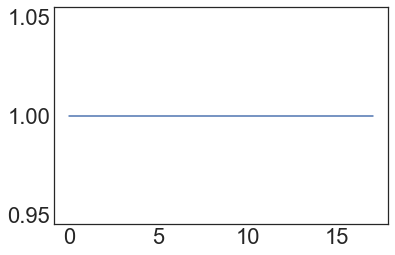

In [118]:
plt.plot(y_pred_block)

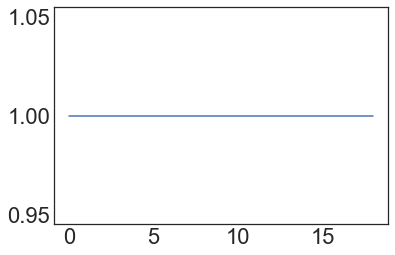

In [119]:
plt.plot(y_pred_fxn[6,:]+1)

In [141]:
series_idxs = np.where(series_labels_sub==0)[0]

block_labels_series = block_labels_sub[series_idxs]
target_labels_series = target_labels_sub[series_idxs]

blocks = np.array([k for k,g in groupby(block_labels_series)])
classes = np.array([k for k,g in groupby(target_labels_series)])

print(blocks,classes)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24.] [0. 1. 0. 2. 0. 3. 0. 4. 0. 5. 0. 6. 0. 1. 0. 2. 0. 3. 0. 4. 0. 5. 0. 6.
 0.]


In [142]:
shuffled_blocks = []
for x in np.random.permutation(np.arange(blocks.size//2)):
    start_idx = 2*x
    shuffled_blocks.extend(blocks[start_idx:start_idx+2].astype('int'))
if (blocks.size%2)==1:
    shuffled_blocks.extend(np.array([blocks[-1]]).astype('int'))
print(shuffled_blocks)

[16, 17, 20, 21, 8, 9, 18, 19, 0, 1, 22, 23, 6, 7, 4, 5, 2, 3, 14, 15, 10, 11, 12, 13, 24]


In [144]:
target_labels_shuffled = np.empty((0,))
for b in shuffled_blocks:
    target_labels_shuffled = np.hstack((target_labels_shuffled,target_labels_series[np.where(block_labels_series==b)[0]]))

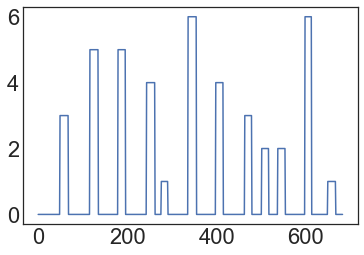

In [145]:
plt.plot(target_labels_shuffled)

In [140]:
target_labels_shuffled.shape

(1346,)